In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp # for reference

import autograd.numpy as np
from neuralsolver import NNSolver

import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
import time

# figure settings
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['legend.fontsize'] = 13

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 15

In [2]:
def plot_loss_compare(model, maxiter = 1000, iprint = 200):
    model.reset_weights()
    save_init_paras_list = model.params_list
    save_init_flattened_params = model.flattened_params
    
    
    methods = ['CG','BFGS','L-BFGS-B']
    
    plt.figure(figsize=(8,6))
    for method in methods:
        
        model.params_list = save_init_paras_list
        model.flattened_params = save_init_flattened_params
        
        start_time = time.time()
        model.train(method = method, maxiter=maxiter, iprint=iprint)
        duration = time.time() - start_time
        
        plt.semilogy(range(len(model.loss)), model.loss, label = method + ' (time = {}s'.format(round(duration,2)) + ')')
        
    plt.legend()
    plt.title("Log Loss Comparision", fontsize = 20)
    plt.xlabel("Iteration")
    plt.ylabel("Log Loss")
    plt.show()

# Problem Definition

In [3]:
# define ODE problem
# Rossler attractor system

def f(t, y):
    a = 0.2
    b = 0.2
    c = 5.7
    return [y[1] - y[2], y[0]+a*y[1], b+y[2]*(y[0]-c)]

t = np.linspace(0, 1, 40).reshape(-1, 1) #increase training points
# t = np.concatenate([np.linspace(0, 1.6, 10), np.linspace(1.7, 2.5,100)])
# t = t.reshape(-1, 1)

y0_list = [1, 5, 10] 

# Reference solution

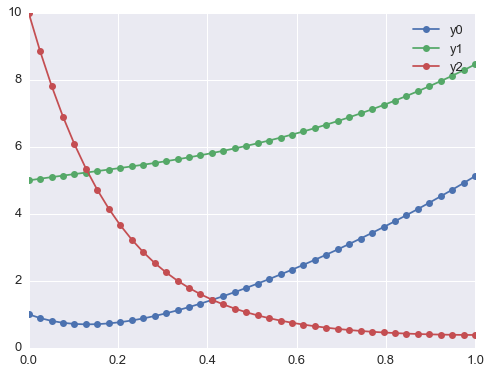

In [4]:
# reference solution using scipy package
sol = solve_ivp(f, [t.min(), t.max()], y0_list, 
                t_eval=t.ravel(), method='Radau', rtol=1e-5)
plt.plot(sol.t, sol.y[0], marker='o', label='y0')
plt.plot(sol.t, sol.y[1], marker='o', label='y1')
plt.plot(sol.t, sol.y[2], marker='o', label='y2')
plt.legend()

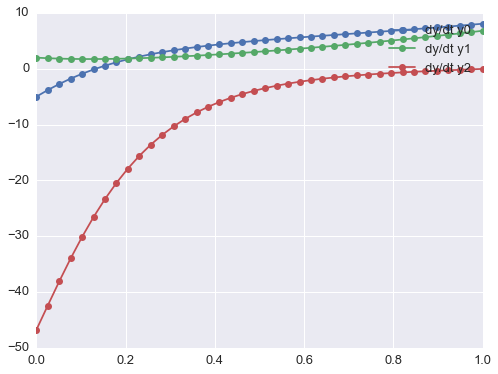

In [8]:
# reference solution using scipy package
plt.plot(sol.t, f(sol.t, sol.y)[0], marker='o', label='dy/dt y0')
plt.plot(sol.t, f(sol.t, sol.y)[1], marker='o', label='dy/dt y1')
plt.plot(sol.t, f(sol.t, sol.y)[2], marker='o', label='dy/dt y2')
plt.legend()

# Neural Net Training

In [9]:
nn = NNSolver(f, t, y0_list, n_hidden=50)
nn

Neural ODE Solver 
Number of equations:       3 
Initial condition y0:      [1, 5, 10] 
Numnber of hidden units:   50 
Number of training points: 40 

In [10]:
nn.reset_weights()
%time nn.train(maxiter=1000, iprint=100)

iteration: 0 loss:  957.311964763
iteration: 100 loss:  3.95041189357e-05
iteration: 200 loss:  5.0835477483e-06
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 233
         Function evaluations: 253
         Gradient evaluations: 253
CPU times: user 10.2 s, sys: 144 ms, total: 10.4 s
Wall time: 6.92 s


# Verifying training set

In [11]:
y_pred_list, dydt_pred_list = nn.predict()

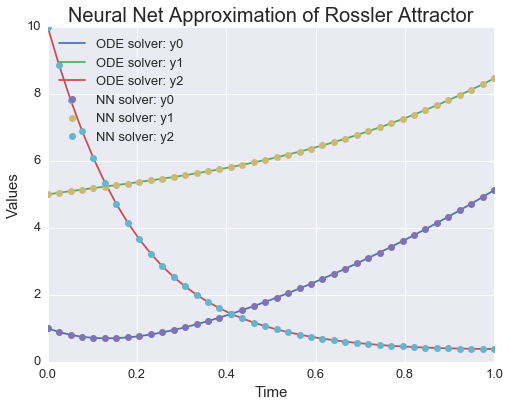

In [12]:
plt.figure(figsize= (8, 6))
# scipy sol
plt.plot(sol.t, sol.y[0], label='ODE solver: y0')
plt.plot(sol.t, sol.y[1], label='ODE solver: y1')
plt.plot(sol.t, sol.y[2], label='ODE solver: y2')

# nn soln
plt.plot(t, y_pred_list[0], 'o', label='NN solver: y0')
plt.plot(t, y_pred_list[1], 'o', label='NN solver: y1')
plt.plot(t, y_pred_list[2], 'o', label='NN solver: y2')

plt.legend(loc = "best")
plt.title('Neural Net Approximation of Rossler Attractor')
plt.ylabel('Values')
plt.xlabel('Time')

In [13]:
np.mean([sqrt(mean_squared_error(sol.y[i], y_pred_list[i])) for i in range(3)])

6.4969702523959193e-05

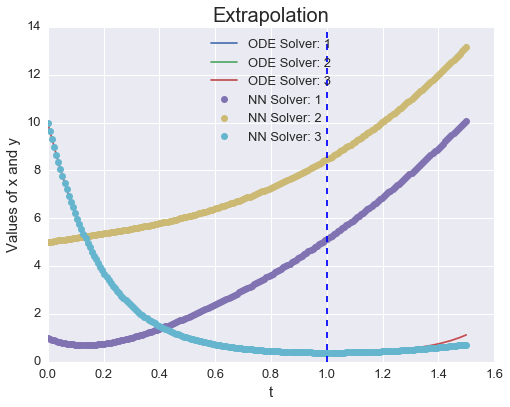

In [14]:
# not used 
t_test = np.linspace(0., 1.5, 200).reshape(-1,1)

sol = solve_ivp(f, [t_test.min(), t_test.max()], y0_list, method='Radau', rtol=1e-5)
y_pred_list, dydt_pred_list = nn.predict(t=t_test)
plt.figure(figsize=(8, 6))
plt.plot(sol.t, sol.y[0], label='ODE Solver: 1')
plt.plot(sol.t, sol.y[1], label='ODE Solver: 2')
plt.plot(sol.t, sol.y[2], label='ODE Solver: 3')

plt.plot(t_test, y_pred_list[0], 'o', label='NN Solver: 1')
plt.plot(t_test, y_pred_list[1], 'o', label='NN Solver: 2')
plt.plot(t_test, y_pred_list[2], 'o', label='NN Solver: 3')
plt.axvline(x = 1 , linestyle = '--')
plt.legend(loc = 'best')
plt.title('Extrapolation')
plt.ylabel('Values of x and y')
plt.xlabel('t')

# Performance over 100 Fittings

In [5]:
res_arr = []
for _ in range(100):
    nn = NNSolver(f, t, y0_list, n_hidden=20)
    nn.reset_weights()
    nn.train(maxiter=500)
    y_pred_list, dydt_pred_list = nn.predict()
    res_arr.append(np.mean([sqrt(mean_squared_error(sol.y[i], y_pred_list[i])) for i in range(3)]))

iteration: 0 loss:  638.049053584
iteration: 200 loss:  1.0818659496e-06
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 213
         Function evaluations: 234
         Gradient evaluations: 234
iteration: 0 loss:  1091.45355012
iteration: 200 loss:  1.25640536253e-05
iteration: 400 loss:  1.73736975872e-06
         Current function value: 0.000000
         Iterations: 500
         Function evaluations: 530
         Gradient evaluations: 530
iteration: 0 loss:  837.211259613
iteration: 200 loss:  2.85249512231e-05
iteration: 400 loss:  5.32870072596e-06
         Current function value: 0.000001
         Iterations: 500
         Function evaluations: 543
         Gradient evaluations: 543
iteration: 0 loss:  884.383281917
iteration: 200 loss:  1.34047530127e-05
iteration: 400 loss:  4.20508544529e-07
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 423
         Function evaluations: 

(array([  7.,  16.,  22.,  13.,  19.,  10.,   9.,   2.,   1.,   0.,   0.,
         0.,   0.,   0.,   1.]), array([  7.00350348e-06,   1.22231390e-05,   1.74427744e-05,
         2.26624099e-05,   2.78820454e-05,   3.31016809e-05,
         3.83213164e-05,   4.35409519e-05,   4.87605874e-05,
         5.39802228e-05,   5.91998583e-05,   6.44194938e-05,
         6.96391293e-05,   7.48587648e-05,   8.00784003e-05,
         8.52980358e-05]), <a list of 15 Patch objects>)


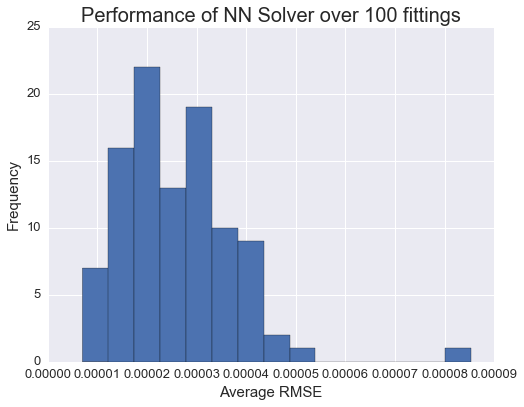

In [7]:
plt.figure(figsize= (8, 6))
figr = plt.hist(res_arr, bins=15)
plt.title('Performance of NN Solver over 100 fittings')
plt.xlabel('Average RMSE')
plt.ylabel('Frequency')
print (figr)

# Compare across different optimization methods

iteration: 0 loss:  668.045517218
iteration: 200 loss:  0.00740043343413
iteration: 400 loss:  0.00387979610595
iteration: 600 loss:  0.00257303885643
iteration: 800 loss:  0.00172465942812
         Current function value: 0.000642
         Iterations: 1000
         Function evaluations: 1781
         Gradient evaluations: 1781
iteration: 0 loss:  668.045517218
iteration: 200 loss:  1.26103360886e-05
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 353
         Function evaluations: 385
         Gradient evaluations: 385
iteration: 0 loss:  673.742055229
iteration: 200 loss:  0.00495206658715
iteration: 400 loss:  0.0012128255566
iteration: 600 loss:  0.000241272048782
iteration: 800 loss:  6.93793431538e-05
iteration: 1000 loss:  4.13426370459e-05


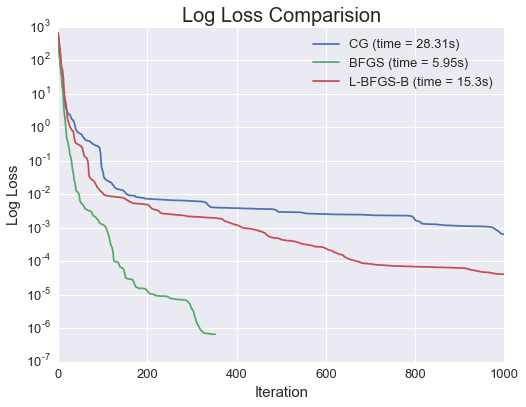

In [8]:
plot_loss_compare(nn)